## Learning from Data Week 7

In [45]:
from __future__ import division
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

In [2]:
train = pd.read_table("in.dta", sep=" +", header=None, engine='python')
train.columns = ["x1", "x2", "y"]
test = pd.read_table("out.dta", sep=" +", header=None, engine='python')
test.columns = ["x1", "x2", "y"]

In [4]:
train.head()

,x1,x2,y
0,-0.779470,0.838221,1
1,0.155635,0.895377,1
2,-0.059908,-0.717780,1
3,0.207596,0.758933,1
4,-0.195983,-0.375487,-1


In [5]:
for df in [train, test]:
    df['one'] = 1
    df['x1^2'] = df['x1']**2
    df['x2^2'] = df['x2']**2
    df['x1x2'] = df['x1']*df['x2']
    df['|x1-x2|'] = np.abs(df['x1'] - df['x2'])
    df['|x1+x2|'] = np.abs(df['x1'] + df['x2'])

In [6]:
train = train.reindex(columns = ['one', 'x1', 'x2', 'x1^2', 'x2^2', 'x1x2', '|x1-x2|', '|x1+x2|', 'y'])
test = test.reindex(columns = ['one', 'x1', 'x2', 'x1^2', 'x2^2', 'x1x2', '|x1-x2|', '|x1+x2|', 'y'])

In [7]:
train.head()

,one,x1,x2,x1^2,x2^2,x1x2,|x1-x2|,|x1+x2|,y
0,1,-0.779470,0.838221,0.607574,0.702615,-0.653369,1.617692,0.058751,1
1,1,0.155635,0.895377,0.024222,0.801701,0.139352,0.739743,1.051012,1
2,1,-0.059908,-0.717780,0.003589,0.515208,0.043001,0.657872,0.777688,1
3,1,0.207596,0.758933,0.043096,0.575980,0.157552,0.551337,0.966530,1
4,1,-0.195983,-0.375487,0.038409,0.140991,0.073589,0.179504,0.571470,-1


### Problem 1

In [30]:
def LR_validation(train_set, val_set):
    ks = range(3,8)
    errors = []
    for k in ks:
        # Calculate weights
        w = np.dot(np.linalg.pinv(train_set.ix[:, :k+1]), train_set['y'])
        # Predict and evaluate on validation set
        y_est = np.sign(np.dot(val_set.ix[:, :k+1], w))
        error = np.mean(y_est != val_set['y'])
        errors.append(error)
    best_k = ks[np.argmin(errors)]
    print zip(ks, errors)
    print "Best k: {}".format(best_k)

LR_validation(train[:25], train[25:])

[(3, 0.29999999999999999), (4, 0.5), (5, 0.20000000000000001), (6, 0.0), (7, 0.10000000000000001)]
Best k: 6


k = 6 (6 parameters) performed the best.

### Problem 2

In [32]:
# Evaluate on TEST set
LR_validation(train[:25], test)

[(3, 0.41999999999999998), (4, 0.41599999999999998), (5, 0.188), (6, 0.084000000000000005), (7, 0.071999999999999995)]
Best k: 7


### Problem 3

In [34]:
# Reverse train/validation order
LR_validation(train[25:], train[:25])

[(3, 0.28000000000000003), (4, 0.35999999999999999), (5, 0.20000000000000001), (6, 0.080000000000000002), (7, 0.12)]
Best k: 6


### Problem 4

In [36]:
# Reverse train/validation order and evaluate on TEST set
LR_validation(train[25:], test)

[(3, 0.39600000000000002), (4, 0.38800000000000001), (5, 0.28399999999999997), (6, 0.192), (7, 0.19600000000000001)]
Best k: 6


### Problem 6

(0.50210042420517842, 0.49932306134428783, 0.33392841354727337)


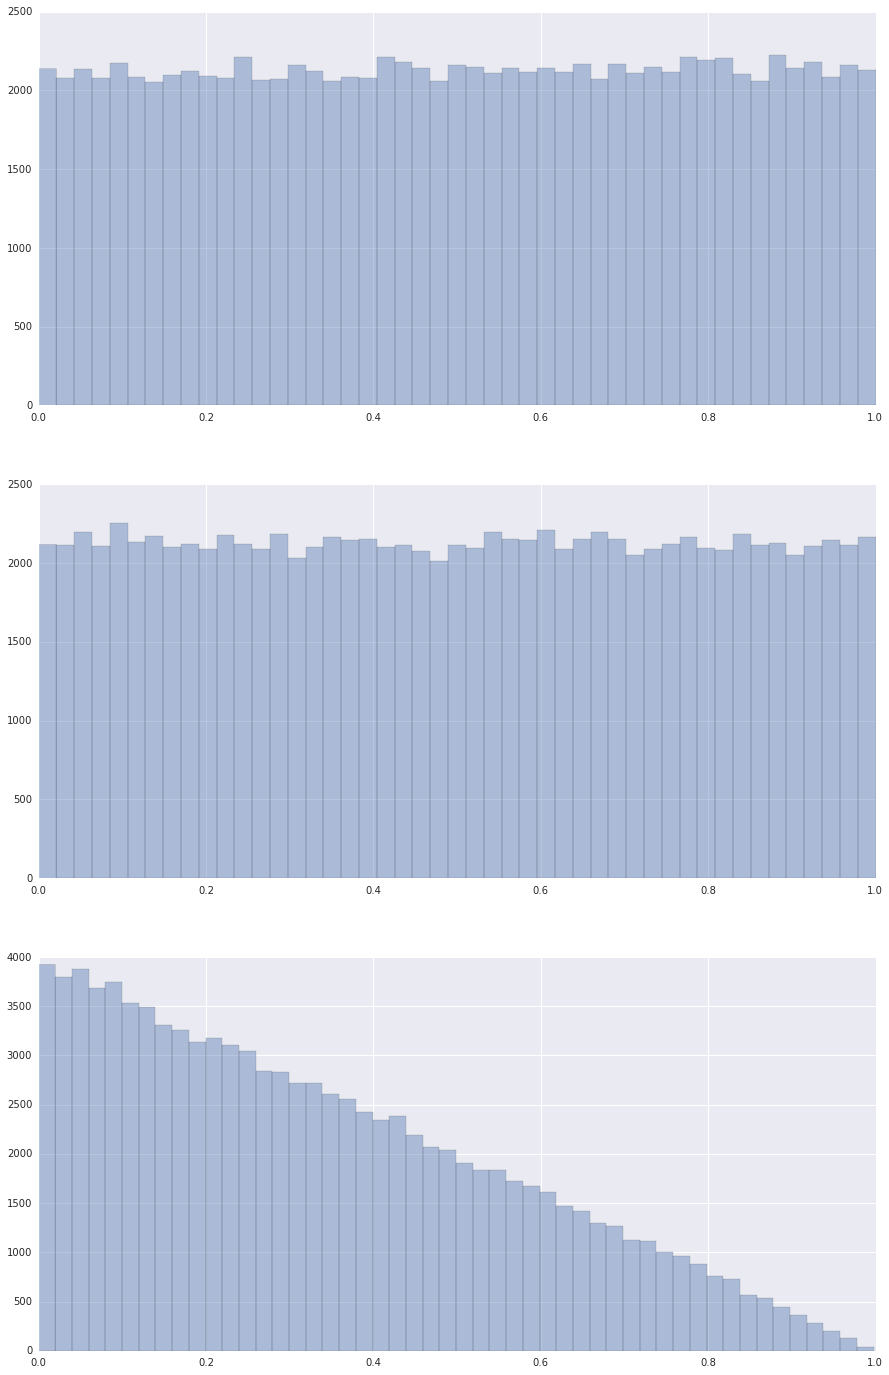

In [50]:
# Validation bias
def validation_bias():
    e_1, e_2 = np.random.uniform(size=100000), np.random.uniform(size=100000)
    e_min = np.minimum(e_1, e_2)
    print (np.mean(e_1), np.mean(e_2), np.mean(e_min))
    
    # Plot figures
    plt.figure(figsize=(15,24))
    for i, v in enumerate([e_1, e_2, e_min]):
        plt.subplot(3, 1, i+1)
        sns.distplot(v, kde=False)
        
validation_bias()